# CV-HW4-HUT
# February, 2026
# Teammates:
## Nima Rezaei - 401130373
## Arman Esmaeili - 401130133

**1. Introduction**



*   Goal of the assignment


Training and evaluation of a multi-class neural network with PyTorch, classifying them into 10 clothing categories, as well as analyzing training behavior such as overfitting and loss/accuracy curves.

**2. Dataset Loading and Preprocessing**




*   Dataset source
*   Transforms used
*   DataLoader creation



In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load training dataset
train_dataset = datasets.FashionMNIST(root="./data",
                                      train=True,
                                      download=True,
                                      transform=transform
)

# Load test dataset
test_dataset = datasets.FashionMNIST(root="./data",
                                    train=False,
                                    download=True,
                                    transform=transform
)


# Create DataLoaders
batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Dataset info
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


100%|██████████| 26.4M/26.4M [00:01<00:00, 19.2MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.65MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.7MB/s]

Training samples: 60000
Test samples: 10000


**3. Data Exploration and Visualization**


*   Batch shape inspection
*   Sample images with labels
*   Explanation of image size and flattening

In [ ]:
# Get one batch
images, labels = next(iter(train_loader))

print("Images batch shape:", images.shape)
print("Labels batch shape:", labels.shape)

Images batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


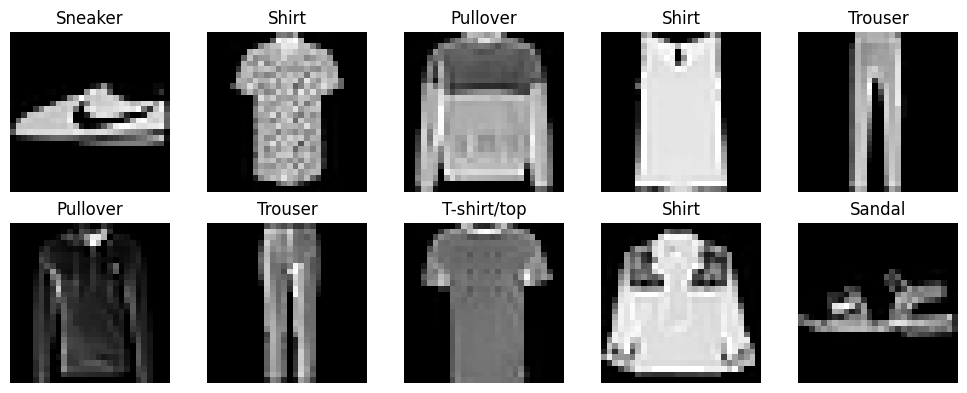

In [ ]:
import matplotlib.pyplot as plt

# Class names in Fashion-MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Plot sample images
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(class_names[labels[i]])
    plt.axis("off")

plt.tight_layout()
plt.show()



*   Image dimensions: Each image in this dataset is 1*28*28, where 1 indicates it is single-channel, i.e., grayscale. Consequently, this means that each image consists of a total of 784 pixels.


*   Reason for flattening:
Fully connected (linear) layers in neural networks receive a one-dimensional vector as input. Therefore, each 28×28 image must be flattened into a vector of size 784 before being fed into the first fully connected layer.




**4. Neural Network Architecture**





*   4.1 Model class definition (784 → 256 → 128 → 10)


In [ ]:
import torch.nn as nn

class FashionMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()               # (B,1,28,28) -> (B,784)
        self.fc1 = nn.Linear(28*28, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, 10)            # logits for 10 classes (no softmax)

    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x




*   4.2 Layer-by-layer explanation (short, report-ready)

    Flatten: converts 28×28 image to 784-length vector.

    FC1 (784→256) + ReLU: learns first set of features (nonlinear).

    FC2 (256→128) + ReLU: compresses into more abstract features.

    FC3 (128→10): outputs logits for 10 classes (no softmax because CE loss handles it)





*   4.3 Number of parameters (important)

    For a Linear layer: params = (in_features × out_features) + out_features (bias)

    FC1: 784×256 + 256 = 200,960

    FC2: 256×128 + 128 = 32,896

    FC3: 128×10 + 10 = 1,290

    Total = 235,146 parameters




*   4.4 Print model summary + confirm parameter count



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = FashionMLP().to(device)
print(model)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total params:", total_params)
print("Trainable params:", trainable_params)


FashionMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)
Total params: 235146
Trainable params: 235146


**5. Loss Function and Optimizer**

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



*   CrossEntropyLoss is standard for multi-class classification (combines LogSoftmax + NLLLoss internally).

*   Adam adapts learning rates per-parameter and usually converges faster than plain SGD for MLP baselines.




**6. Model Training (loop + epoch loss + epoch accuracy)**



*   6.1 Train function


In [ ]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)                  # logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc




*   6.2 Eval function


In [ ]:
@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc




*   6.3 Full training loop (≥ 10 epochs required)



In [ ]:
num_epochs = 10

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(1, num_epochs + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    te_loss, te_acc = evaluate(model, test_loader, criterion, device)

    train_losses.append(tr_loss); train_accs.append(tr_acc)
    test_losses.append(te_loss);  test_accs.append(te_acc)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={tr_loss:.4f}, train_acc={tr_acc*100:.2f}% | "
          f"test_loss={te_loss:.4f}, test_acc={te_acc*100:.2f}%")


Epoch 01: train_loss=0.4901, train_acc=82.16% | test_loss=0.4275, test_acc=84.00%
Epoch 02: train_loss=0.3682, train_acc=86.42% | test_loss=0.3787, test_acc=86.21%
Epoch 03: train_loss=0.3314, train_acc=87.65% | test_loss=0.4000, test_acc=85.79%
Epoch 04: train_loss=0.3077, train_acc=88.49% | test_loss=0.3645, test_acc=86.47%
Epoch 05: train_loss=0.2846, train_acc=89.42% | test_loss=0.3427, test_acc=87.73%
Epoch 06: train_loss=0.2710, train_acc=89.79% | test_loss=0.3487, test_acc=87.08%
Epoch 07: train_loss=0.2570, train_acc=90.40% | test_loss=0.3424, test_acc=87.89%
Epoch 08: train_loss=0.2444, train_acc=90.80% | test_loss=0.3353, test_acc=88.11%
Epoch 09: train_loss=0.2345, train_acc=91.18% | test_loss=0.3387, test_acc=88.15%
Epoch 10: train_loss=0.2241, train_acc=91.60% | test_loss=0.3489, test_acc=88.59%


**7. Model Evaluation (test accuracy + correct/misclassified + error analysis)**





*   7.1 Collect predictions (for correct + misclassified examples)


In [ ]:
import numpy as np

@torch.no_grad()
def collect_predictions(model, loader, device):
    model.eval()
    all_images = []
    all_labels = []
    all_preds = []

    for images, labels in loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()

        all_images.append(images.cpu())
        all_labels.append(labels)
        all_preds.append(preds)

    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    all_preds  = torch.cat(all_preds,  dim=0)
    return all_images, all_labels, all_preds

test_images, test_labels, test_preds = collect_predictions(model, test_loader, device)

test_acc = (test_preds == test_labels).float().mean().item()
print("Final Test Accuracy:", test_acc * 100)


Final Test Accuracy: 88.59000205993652




*   7.2 Show some correct predictions


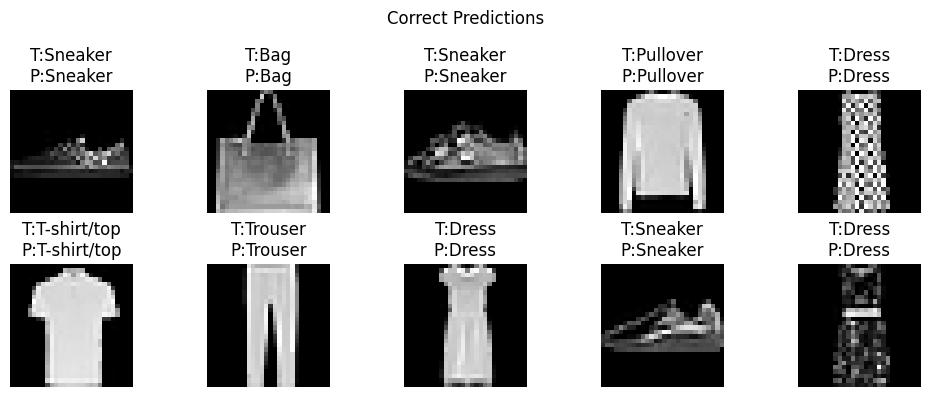

In [ ]:
import matplotlib.pyplot as plt

def show_samples(images, labels, preds, class_names, title, n=10):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[preds[i]]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

correct_idx = (test_preds == test_labels).nonzero(as_tuple=True)[0]
picked = correct_idx[torch.randperm(len(correct_idx))[:10]]

show_samples(test_images[picked], test_labels[picked], test_preds[picked],
             class_names, title="Correct Predictions", n=10)




*   7.3 Show misclassified samples + quick “error analysis”


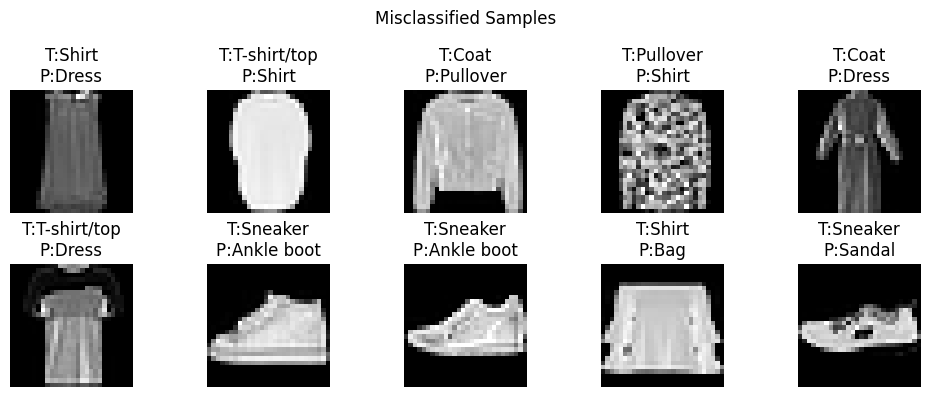

True class 'T-shirt/top' misclassified: 185
True class 'Trouser' misclassified: 29
True class 'Pullover' misclassified: 218
True class 'Dress' misclassified: 89
True class 'Coat' misclassified: 146
True class 'Sandal' misclassified: 68
True class 'Shirt' misclassified: 286
True class 'Sneaker' misclassified: 84
True class 'Bag' misclassified: 17
True class 'Ankle boot' misclassified: 19


In [ ]:
wrong_idx = (test_preds != test_labels).nonzero(as_tuple=True)[0]
picked = wrong_idx[torch.randperm(len(wrong_idx))[:10]]

show_samples(test_images[picked], test_labels[picked], test_preds[picked],
             class_names, title="Misclassified Samples", n=10)

# Which classes are most confused? (simple count of true labels among errors)
wrong_true = test_labels[wrong_idx].numpy()
counts = np.bincount(wrong_true, minlength=10)
for i, c in enumerate(counts):
    print(f"True class '{class_names[i]}' misclassified: {c}")


**8. Training Curves + Overfitting Analysis**

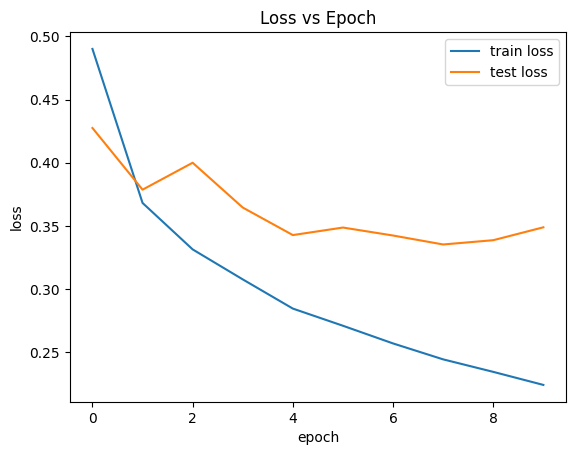

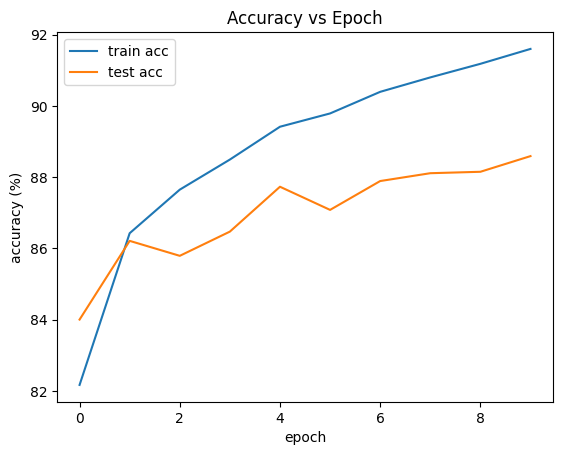

In [ ]:
plt.figure()
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()

plt.figure()
plt.plot([a*100 for a in train_accs], label="train acc")
plt.plot([a*100 for a in test_accs], label="test acc")
plt.xlabel("epoch")
plt.ylabel("accuracy (%)")
plt.legend()
plt.title("Accuracy vs Epoch")
plt.show()




*   The training loss decreases steadily across all epochs, indicating that the model continues to learn meaningful representations from the training data.

    The test loss initially decreases, but after several epochs it stabilizes and shows minor fluctuations while the training loss continues to decrease. This divergence suggests the beginning of overfitting, where the model fits the training data better than the unseen test data.

    However, since the test loss does not increase sharply, the overfitting remains mild and controlled.
*   Training accuracy consistently increases throughout the training process and reaches approximately 91.6%.

    Test accuracy improves rapidly in the early epochs and then gradually plateaus around 88–89%. The gap between training and test accuracy slightly widens over time, which further indicates mild overfitting, but the generalization performance remains stable.

    Overall, the model achieves good performance without significant degradation on the test set.



**9. Conclusion**



In this assignment, a fully connected neural network was trained to classify images from the Fashion-MNIST dataset. The final model achieved a test accuracy of approximately 88.6%, which is a strong result for a baseline multilayer perceptron without convolutional layers.

The training curves show stable convergence with a small gap between training and test performance, indicating mild overfitting but overall good generalization.

Error analysis revealed that most misclassifications occur among visually similar upper-body clothing classes such as Shirt, T-shirt/top, Pullover, and Coat, while distinct categories like Bag, Trouser, and Ankle boot are classified with high accuracy. This limitation is expected due to the lack of spatial feature extraction in a flattened MLP architecture.


